In [1]:
import torch
import time
import yaml
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from ultralytics import YOLO

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# 데이터셋 경로 설정 (yolo는 dataset 경로를 images와 labels로 해주어야 인식이 가능)
data_root = 'D:\\Falldown\\Dataset\\Resized_Dataset'
train_root = f'{data_root}\\Train\\images'
val_root = f'{data_root}\\Val\\images'
test_root = f'{data_root}\\Test\\images'

# 클래스 설정
class_names = {0 : 'Human'} # 팀원 yaml에서는 0을 비낙상, 1을 낙상으로 클래스 설정함
num_classes = len(class_names)

# yaml 설정
yaml_info = {
    'path' : r'D:\Falldown', # YOLOv8 기본 경로
    'names': class_names,
    'nc': num_classes,
    'train': train_root,
    'val': val_root,
    'test': test_root
}

# YAML 파일 저장 경로
yaml_file_path = 'D:\\Falldown\\yaml_info_yolov8s.yaml'

# YAML 파일 생성 또는 확인
if os.path.exists(yaml_file_path):
    print(f"YAML 파일이 이미 존재합니다: {yaml_file_path}")
else:
    with open(yaml_file_path, 'w') as f:
        yaml.dump(yaml_info, f)
    print(f"YAML 파일이 생성되었습니다: {yaml_file_path}")

YAML 파일이 이미 존재합니다: D:\Falldown\yaml_info_yolov8s.yaml


In [5]:
model = YOLO('yolov8s.pt')

In [6]:
# 학습 디렉토리 이름 설정
training_name = 'human_fall_s'
training_dir = f"D:\\Falldown\\code-git\\runs\\detect\\{training_name}"

try:
    if os.path.exists(training_dir):
        print(f"학습이 이미 완료된 디렉토리가 존재합니다: {training_dir}")
    else:
        start_time = time.time()

        # 학습 실행
        result = model.train(
            data='D:\\Falldown\\yaml_info_yolov8s.yaml',
            epochs=50,
            batch=16,
            imgsz=640,
            device=device,
            workers=12,
            amp=True,
            patience=30,
            name=training_name
        )

        end_time = time.time()
        execution_time = end_time - start_time
        print(f"학습 실행 시간: {execution_time:.4f} 초")  # 약 20시간 소요

except KeyboardInterrupt:
    print("KeyboardInterrupt: 사용자가 학습을 중단하였습니다.")

학습이 이미 완료된 디렉토리가 존재합니다: D:\Falldown\code-git\runs\detect\human_fall_s


In [12]:
# Validation 결과 캐시 파일 경로
val_cache_file = f"{training_dir}\\val_results_cache.pt"

# Validation 시작 혹은 캐시 로드
val_results = None
if os.path.exists(val_cache_file):
    try:
        print(f"Cached validation results found: {val_cache_file}")
        val_results = torch.load(val_cache_file)
    except (RuntimeError, FileNotFoundError) as e:
        print(f"Error loading cache file: {e}")
        print(f"Deleting corrupted cache file: {val_cache_file}")
        os.remove(val_cache_file)

if val_results is None: # 캐시가 없거나 손상된 경우 검증 실행
    print("Recomputing validation results...")
    start_time = time.time()
    model_path = f'{training_dir}\\weights\\best.pt'

    # YOLO 모델 로드 및 검증 실행
    model = YOLO(model_path)
    val_results_raw = model.val(
        data='D:\\Falldown\\yaml_info_yolov8s.yaml',
        imgsz=640,
        batch=32,
        device=device
    )

    # 평가 종료 시간 기록
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"검증 실행 시간: {execution_time:.4f} 초")

    # 필요한 정보만 추출하여 저장
    val_results = {
        "mAP50": val_results_raw.box.map50,
        "mAP50-95": val_results_raw.box.map,
        "execution_time": execution_time,
    }
    print(f"Saving validation results to cache: {val_cache_file}")
    torch.save(val_results, val_cache_file)

# 결과 출력
print(f"Validation Results:")
print(f"mAP50: {val_results['mAP50']:.4f}")
print(f"mAP50-95: {val_results['mAP50-95']:.4f}")
print(f"Execution Time: {val_results['execution_time']:.4f} 초")

Cached validation results found: D:\Falldown\code-git\runs\detect\human_fall_s\val_results_cache.pt
Validation Results:
mAP50: 0.8267
mAP50-95: 0.8099
Execution Time: 112.2721 초


In [14]:
# Test 결과 캐시 파일 경로
test_cache_file = f"{training_dir}\\test_results_cache.pt"

# Test 시작 혹은 캐시 로드
test_results = None
if os.path.exists(test_cache_file):
    try:
        print(f"Cached test results found: {test_cache_file}")
        test_results = torch.load(test_cache_file)
    except (RuntimeError, FileNotFoundError) as e:
        print(f"Error loading cache file: {e}")
        print(f"Deleting corrupted cache file: {test_cache_file}")
        os.remove(test_cache_file)

if test_results is None:  # 캐시가 없거나 손상된 경우 테스트 실행
    print("Recomputing test results...")
    start_time = time.time()
    
    # YOLO 모델 로드 및 테스트 실행
    model = YOLO(model_path)
    test_results_raw = model.val(
        data='D:\\Falldown\\yaml_info_yolov8s.yaml',
        imgsz=640,
        batch=32,
        device=device,
        split="test"  # Test 데이터셋으로 평가
    )

    # 테스트 종료 시간 기록
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"테스트 실행 시간: {execution_time:.4f} 초")

    # 필요한 정보만 추출하여 저장
    test_results = {
        "mAP50": test_results_raw.box.map50,
        "mAP50-95": test_results_raw.box.map,
        "execution_time": execution_time,
    }
    print(f"Saving test results to cache: {test_cache_file}")
    torch.save(test_results, test_cache_file)

# 테스트 결과 출력
print(f"Test Results:")
print(f"mAP50: {test_results['mAP50']:.4f}")
print(f"mAP50-95: {test_results['mAP50-95']:.4f}")
print(f"Execution Time: {test_results['execution_time']:.4f} 초")

Cached test results found: D:\Falldown\code-git\runs\detect\human_fall_s\test_results_cache.pt
Test Results:
mAP50: 0.8332
mAP50-95: 0.8146
Execution Time: 151.6862 초


In [32]:
# 경로 설정
data_root = 'D:\\Falldown\\Dataset\\Resized_Dataset'
test_root = f'{data_root}\\Test\\images'

# YOLO 모델 로드
model_path = "D:\\Falldown\\code-git\\runs\\detect\\human_fall_s\\weights\\best.pt"
model = YOLO(model_path)

# 랜덤 테스트 이미지 10개 가져오기
image_files = [os.path.join(test_root, file) for file in os.listdir(test_root) if file.endswith('.jpg')]
random.shuffle(image_files)
selected_images = image_files[:10]

# 시각화 함수
def process_and_visualize(image, model, conf=0.5):
    results = model.predict(image, conf=conf, save=False, verbose=False)
    for result in results:
        for box in result.boxes.xyxy.tolist(): # Tensor -> 리스트로 변환
            x1, y1, x2, y2 = map(int, box[:4])
            cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
    return image

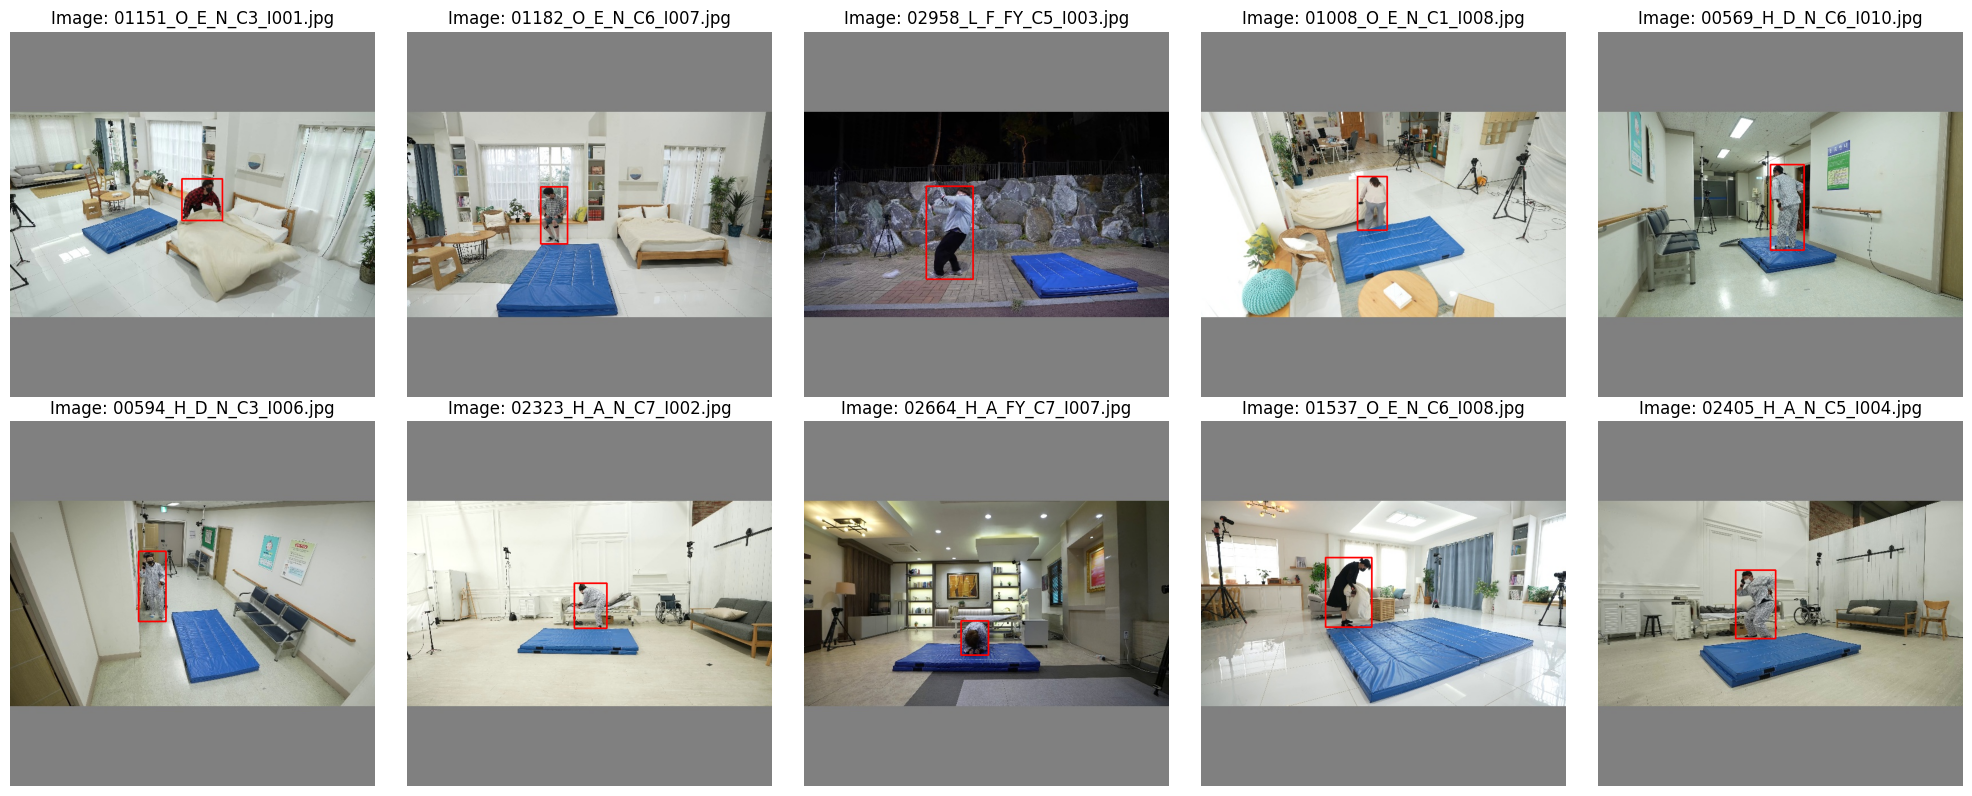

In [34]:
%matplotlib inline
# subplot 설정
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 이미지 처리 및 시각화
for idx, image_path in enumerate(selected_images):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load {image_path}")
        continue

    processed_image = process_and_visualize(image, model, conf=0.5)

    # RGB로 변환 후 subplot에 추가
    image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f"Image: {os.path.basename(image_path)}")

# 빈 subplot 처리
for ax in axes[len(selected_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()